# Import necessary Libraries

In [1]:
import gym
import torch
import numpy as np
from ipynb.fs.full.BreakoutPPO import Agent
from utils import plot_learning_curve

# Preprocess Breakout Environment for Faster Training

In [2]:
# Preprocess image(Code from class)
def prepro(image):
    image = image[35:195]  # crop
    image = image[::2, ::2, 0]  # downsample by factor of 2
    image[image == 144] = 0  # erase background (background type 1)
    image[image == 109] = 0  # erase background (background type 2)
    image[image != 0] = 1  # everything else (paddles, ball) just set to 1
    return np.reshape(image, (1, 80, 80))

# Setup Breakout Environment

/Users/stanleyaraki/miniconda3/lib/python3.9/site-packages/gym/utils/seeding.py:138: DeprecationWarning: WARN: Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(
/Users/stanleyaraki/miniconda3/lib/python3.9/site-packages/gym/utils/seeding.py:175: DeprecationWarning: WARN: Function `_bigint_from_bytes(bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(


... loading models ...
... saving models ...
episode 0 score 0.0 avg score 0.0 time_steps 251 learning_steps 12
... saving models ...
episode 1 score 7.0 avg score 3.5 time_steps 772 learning_steps 38
episode 2 score 2.0 avg score 3.0 time_steps 1074 learning_steps 53
episode 3 score 3.0 avg score 3.0 time_steps 1297 learning_steps 64
episode 4 score 4.0 avg score 3.2 time_steps 1542 learning_steps 77
... saving models ...
episode 5 score 11.0 avg score 4.5 time_steps 2227 learning_steps 111
... saving models ...
episode 6 score 7.0 avg score 4.9 time_steps 2628 learning_steps 131
episode 7 score 1.0 avg score 4.4 time_steps 2779 learning_steps 138
episode 8 score 6.0 avg score 4.6 time_steps 3112 learning_steps 155
episode 9 score 7.0 avg score 4.8 time_steps 3360 learning_steps 168
episode 10 score 3.0 avg score 4.6 time_steps 3585 learning_steps 179
... saving models ...
episode 11 score 11.0 avg score 5.2 time_steps 3938 learning_steps 196
... saving models ...
episode 12 score 11.

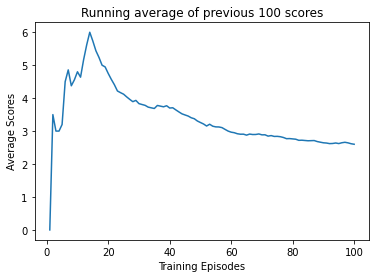

In [5]:
if __name__ == '__main__':
    env = gym.make('BreakoutDeterministic-v4')
    N = 20
    batch_size = 5
    n_epochs = 4
    alpha = 0.0003

    raw_image = env.reset()
    preprocessed_image = prepro(raw_image) #(1, 80, 80)

    flattened = preprocessed_image.flatten()
    agent = Agent(num_actions = env.action_space.n, batch_size = 5, alpha = 0.0003, num_epochs = 4, input_dims = flattened.shape)
    n_games = 100 # 45 mins for 100 iterations of training

    figure_file = 'plots/Breakout.png'

    best_score = env.reward_range[0]
    score_history = []

    learn_iters = 0
    avg_score = 0
    n_steps = 0

    # Load model
    agent.load_models()
    
    for i in range(n_games): 
        observation = env.reset()
        done = False
        score = 0
        while not done:
            observation = prepro(observation) # need to preprocess each time
            action, prob, val = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            n_steps += 1
            score += reward
            agent.remember(observation, action, prob, val, reward, done)
            if n_steps % N == 0: # if true, it's time to perform learning function
                agent.learn()
                learn_iters += 1
            observation = observation_
        score_history.append(score)
        avg_score = np.mean(score_history[-100:])

        if avg_score > best_score: # if best score found
            best_score = avg_score
            agent.save_models()

        print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score,
                'time_steps', n_steps, 'learning_steps', learn_iters)
    x = [i+1 for i in range(len(score_history))]
    plot_learning_curve(x, score_history, figure_file, "Training Episodes", "Average Scores")